Neural Network is a series of algorithm which tries to recognize the relationship among data by depicting how the human brain things. It consists of several layers compiling before using the final trained model.
Some of the key terms are

**Layers** - There are many types of layers present specific to its usecase
- **Dense** - fully connected layer, which connects each neuron in the layer to each neurons in the next layer
- **Convolutional** - this layes is used in image data processing

**Neurons** - are the building blocks of a layer. Each neuron does a weighted sum of all its input and adds a constant bias and feeds that to an activation function.

*neuron = activation_function(weighted_sum_of_inputs)*

**Logit** - output of the layer of neuron before the activation function is called logits

**Activation Function** - 
- **relu** - stands for Rectified Linear Unit. Shows better result than sigmoid function as it is more simple and have better convergense properties.
- **softmax** - Softmax function converts the scores to the normalised probability which can be used to display it to a user or used as a input to the other systems. It first steeply increases the difference between neurons and then normalises the vector(dividing by L1 norm) so that the value which is dominating gets close to 1 and all other values normalises close to 0. Therefore, softmax is generally the last layer in a neural network
- **sigmoid** - It is the traditional activation function.

**Loss Function** - is used to predict the difference between the prediction and the correct value of the function
- **cross_entropy** - it is the most effective measure in classificatio problems.

**Gradient Descent** - When we train the model with different values, we plot the graph in final to look at the output of each value. Our aim is to reach a point of zero slope on that curve. **Learning Rate** - We do not learn the weights and bias in the single hit. We do it gradually with fractions, that is knows as learning rate. The concept of mini batching and momentum is called as stochastic gradient descent. It has the pragmatic benifit of working with larger matrices and easier to optimise on GPU and TPU.

Optimisers provided by tenserflow library are
- tf.keras.optimizers.SGD
- tf.keras.optimizers.Adam
- tf.keras.optimizers.RMSprop

**Tensor** - It is a matrix which can have arbitary number of dimensions. 1D - vector, 2D - matrix and 3,4,5 so on

In [ ]:
BATCH_SIZE, EPOCHS = 128, 10
training_images   = 'gs://mnist-public/train-images-idx3-ubyte'
training_labels   = 'gs://mnist-public/train-labels-idx1-ubyte'
validation_images = 'gs://mnist-public/t10k-images-idx3-ubyte'
validation_labels = 'gs://mnist-public/t10k-labels-idx1-ubyte'

In [ ]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
#Import the tensor flow api of python for performing deep learning algorithms
import tensorflow as tf
from matplotlib import pyplot as plt

In [ ]:
#@title visualization utilities [RUN ME]
"""
This cell contains helper functions used for visualization
and downloads only. You can skip reading it. There is very
little useful Keras/Tensorflow code here.
"""

# Matplotlib config
plt.ioff()
plt.rc('image', cmap='gray_r')
plt.rc('grid', linewidth=1)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0', figsize=(16,9))
# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# pull a batch from the datasets. This code is not very nice, it gets much better in eager mode (TODO)
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
  
  # get one batch from each: 10000 validation digits, N training digits
  batch_train_ds = training_dataset.unbatch().batch(N)
  
  # eager execution: loop through datasets normally
  if tf.executing_eagerly():
    for validation_digits, validation_labels in validation_dataset:
      validation_digits = validation_digits.numpy()
      validation_labels = validation_labels.numpy()
      break
    for training_digits, training_labels in batch_train_ds:
      training_digits = training_digits.numpy()
      training_labels = training_labels.numpy()
      break
    
  else:
    v_images, v_labels = validation_dataset.make_one_shot_iterator().get_next()
    t_images, t_labels = batch_train_ds.make_one_shot_iterator().get_next()
    # Run once, get one batch. Session.run returns numpy results
    with tf.Session() as ses:
      (validation_digits, validation_labels,
       training_digits, training_labels) = ses.run([v_images, v_labels, t_images, t_labels])
  
  # these were one-hot encoded in the dataset
  validation_labels = np.argmax(validation_labels, axis=1)
  training_labels = np.argmax(training_labels, axis=1)
  
  return (training_digits, training_labels,
          validation_digits, validation_labels)

# create digits from local fonts for testing
def create_digits_from_local_fonts(n):
  font_labels = []
  img = PIL.Image.new('LA', (28*n, 28), color = (0,255)) # format 'LA': black in channel 0, alpha in channel 1
  font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
  font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
  d = PIL.ImageDraw.Draw(img)
  for i in range(n):
    font_labels.append(i%10)
    d.text((7+i*28,0 if i<10 else -4), str(i%10), fill=(255,255), font=font1 if i<10 else font2)
  font_digits = np.array(img.getdata(), np.float32)[:,0] / 255.0 # black in channel 0, alpha in channel 1 (discarded)
  font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [28, 28*n]), n, axis=1), axis=0), [n, 28*28])
  return font_digits, font_labels

# utility to display a row of digits with their predictions
def display_digits(digits, predictions, labels, title, n):
  fig = plt.figure(figsize=(13,3))
  digits = np.reshape(digits, [n, 28, 28])
  digits = np.swapaxes(digits, 0, 1)
  digits = np.reshape(digits, [28, 28*n])
  plt.yticks([])
  plt.xticks([28*x+14 for x in range(n)], predictions)
  plt.grid(b=None)
  for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
    if predictions[i] != labels[i]: t.set_color('red') # bad predictions in red
  plt.imshow(digits)
  plt.grid(None)
  plt.title(title)
  display.display(fig)
  
# utility to display multiple rows of digits, sorted by unrecognized/recognized status
def display_top_unrecognized(digits, predictions, labels, n, lines):
  idx = np.argsort(predictions==labels) # sort order: unrecognized first
  for i in range(lines):
    display_digits(digits[idx][i*n:(i+1)*n], predictions[idx][i*n:(i+1)*n], labels[idx][i*n:(i+1)*n],
                   "{} sample validation digits out of {} with bad predictions in red and sorted first".format(n*lines, len(digits)) if i==0 else "", n)

def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0], y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display.display(fig)

class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 60000//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    display.clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)
      
    for k,v in self.epoch_history.items():
      self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
    display.display(self.fig)

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

def read_label(tf_bytestring):
  label = tf.io.decode_raw(tf_bytestring, tf.uint8)
  label = tf.reshape(label, [])
  label = tf.one_hot(label, 10)
  return label
  
def read_image(tf_bytestring):
  image = tf.io.decode_raw(tf_bytestring, tf.uint8)
  image = tf.cast(image, tf.float32)/256.0
  image = tf.reshape(image, [28*28])
  return image
  
def load_dataset(image_file, label_file):
  #images are stored in a fixed length record files
  imagedataset = tf.data.FixedLengthRecordDataset(image_file, 28*28, header_bytes=16)
  imagedataset = imagedataset.map(read_image, num_parallel_calls=16)
  labelsdataset = tf.data.FixedLengthRecordDataset(label_file, 1, header_bytes=8)
  labelsdataset = labelsdataset.map(read_label, num_parallel_calls=16)
  dataset = tf.data.Dataset.zip((imagedataset, labelsdataset))
  return dataset 
  
def get_training_dataset(image_file, label_file, batch_size):
  dataset = load_dataset(image_file, label_file)
  dataset = dataset.cache()  # the dataset can be entirely cached in RAM
  dataset = dataset.shuffle(4000, reshuffle_each_iteration=True)
  dataset = dataset.repeat() # Loops the dataset
  dataset = dataset.batch(batch_size, drop_remainder=True) # pulls multiple images and groups them together
  dataset = dataset.prefetch(AUTO)  # uses CPU to fetch next batches while training on the current one 
  return dataset
  
def get_validation_dataset(image_file, label_file):
  dataset = load_dataset(image_file, label_file)
  dataset = dataset.cache() # the dataset can be entirely cached in RAM
  dataset = dataset.batch(10000, drop_remainder=True) # 10000 items in eval dataset, all in one batch
  dataset = dataset.repeat() # Loops the dataset
  return dataset

# instantiate the datasets
training_dataset = get_training_dataset(training_images, training_labels, BATCH_SIZE)
validation_dataset = get_validation_dataset(validation_images, validation_labels)

# For TPU, we will need a function that returns the dataset
training_input_fn = lambda: get_training_dataset(training_images, training_labels, BATCH_SIZE)
validation_input_fn = lambda: get_validation_dataset(validation_images, validation_labels)

# ***Dense Layer***

**Single Layer, SGD Optimizer**


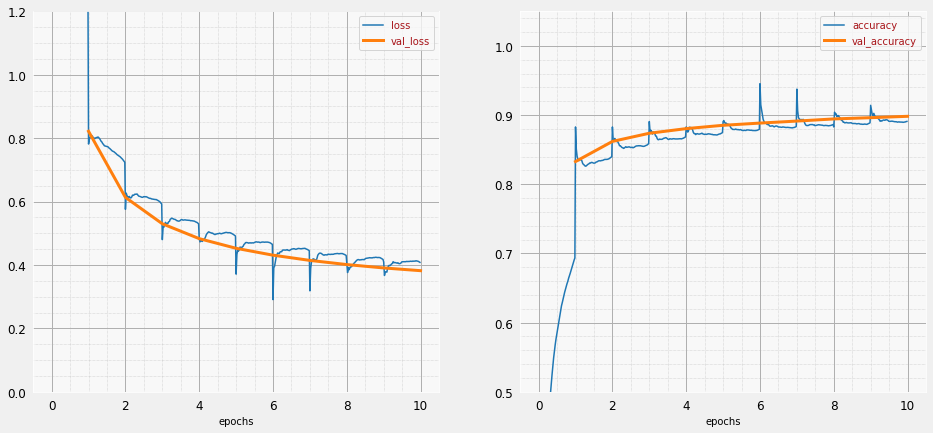

Model accuracy is 90%


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                            #  tf.keras.layers.Dense(200, activation="relu"), #Activation function used is relu for this example
                            #  tf.keras.layers.Dense(100, activation="relu"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='sgd', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is 90%")

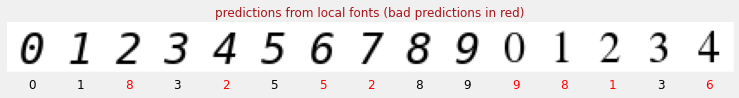

In [ ]:
# recognize digits from local fonts
N=15
font_digits, font_labels = create_digits_from_local_fonts(N)
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)


**3 Layer, Sigmoid + Softmax Activation Function, SGD Optimizer**

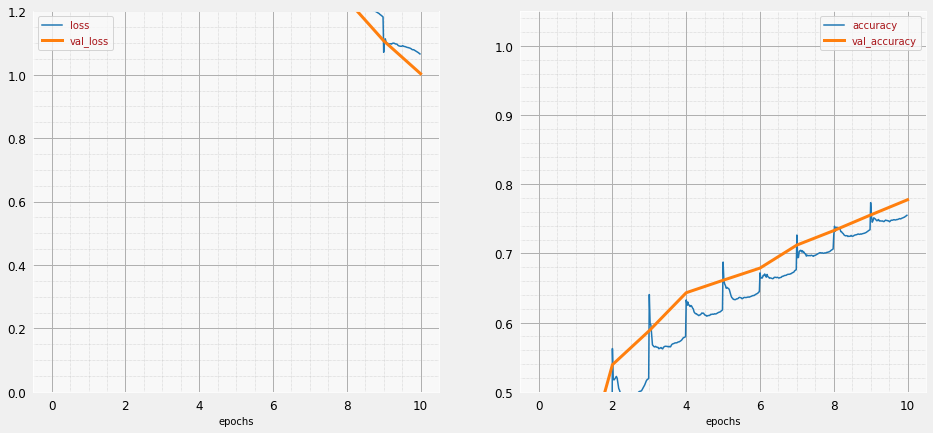

In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="sigmoid"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dense(60, activation="sigmoid"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='sgd', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is around 77%. Decreased with adding layers of sigmoid activation function")

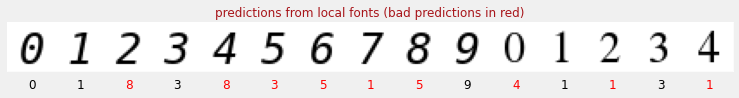

In [ ]:
# recognize digits from local fonts
N=15
font_digits, font_labels = create_digits_from_local_fonts(N)
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

**3 Layer, Relu + Softmax Activation Function, SGD Optimizer**

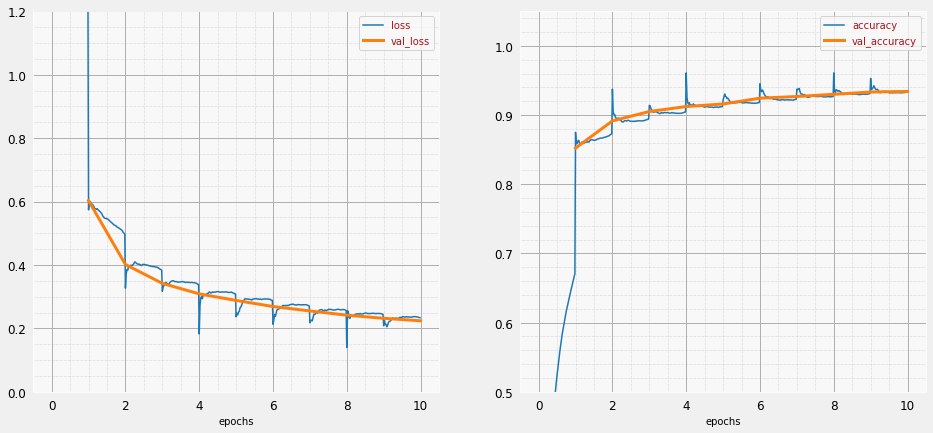

In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="relu"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dense(60, activation="relu"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='sgd', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is around 94%. Increased on adding the same layers with relu activation function")

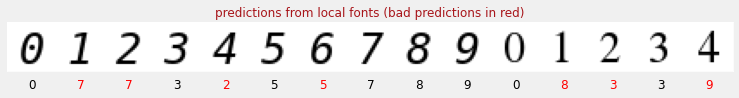

In [ ]:
# recognize digits from local fonts
N=15
font_digits, font_labels = create_digits_from_local_fonts(N)
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

Learning Rate Decay Added

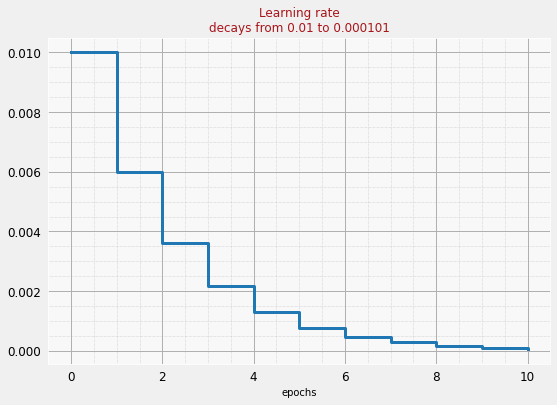

In [ ]:
# Learning Rate decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# Learning Rate schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)
plot_learning_rate(lr_decay, EPOCHS)

**3 Layer, Relu + Softmax Activation Function, Adam Optimizer**

With LR_decay Callback

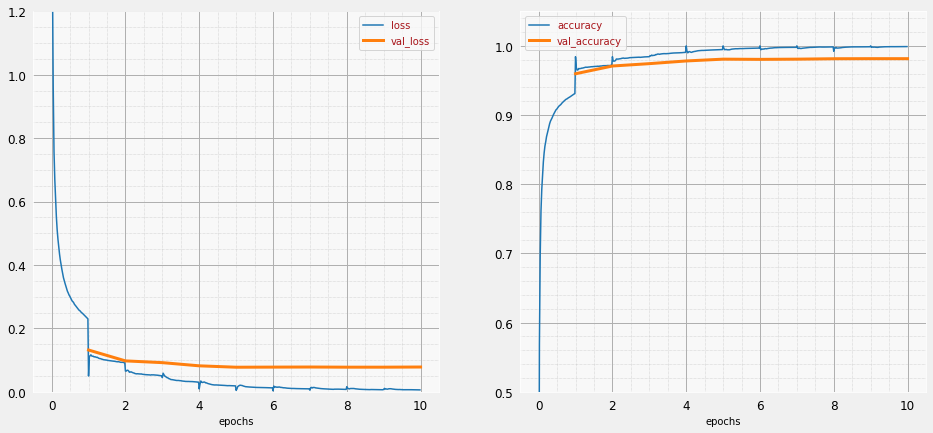

Model accuracy is around 98%. Increased on adding the same layers with relu activation function and adam optimizer


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="relu"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dense(60, activation="relu"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])
print("Model accuracy is around 100%. Increased on adding the same layers with relu activation function and adam optimizer and learning rate callback added")

Without LR_decay Callback

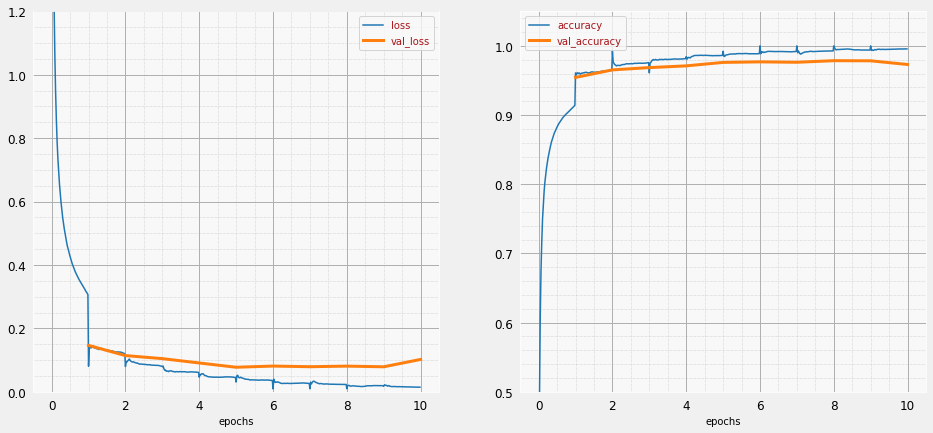

Model accuracy is around 98%. Increased on adding the same layers with relu activation function and adam optimizer


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="relu"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dense(60, activation="relu"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is around 98%. Increased on adding the same layers with relu activation function and adam optimizer")

**3 Layer, Sigmoid + Softmax Activation Function, Adam Optimizer**

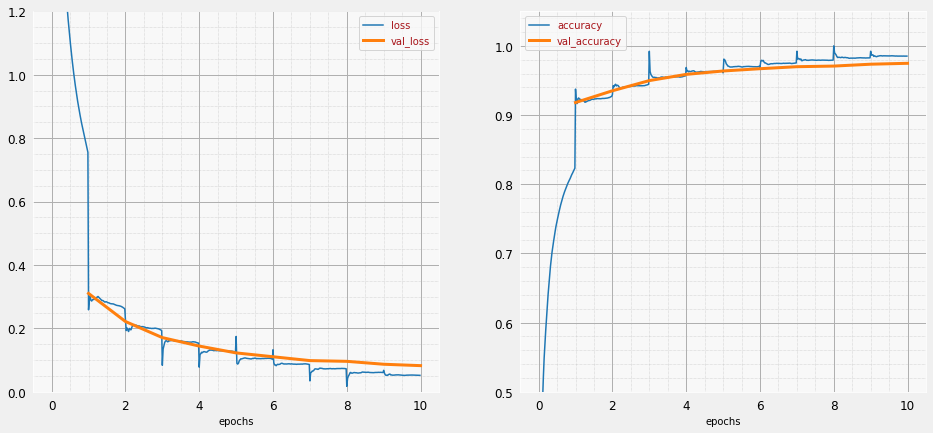

Model accuracy is around 99%. Decreased with adding layers of sigmoid activation function with adam optimizer


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="sigmoid"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dense(60, activation="sigmoid"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is around 99%. Decreased with adding layers of sigmoid activation function with adam optimizer")

**Single Layer, Softmax Activation Function, Adam Optmizer**

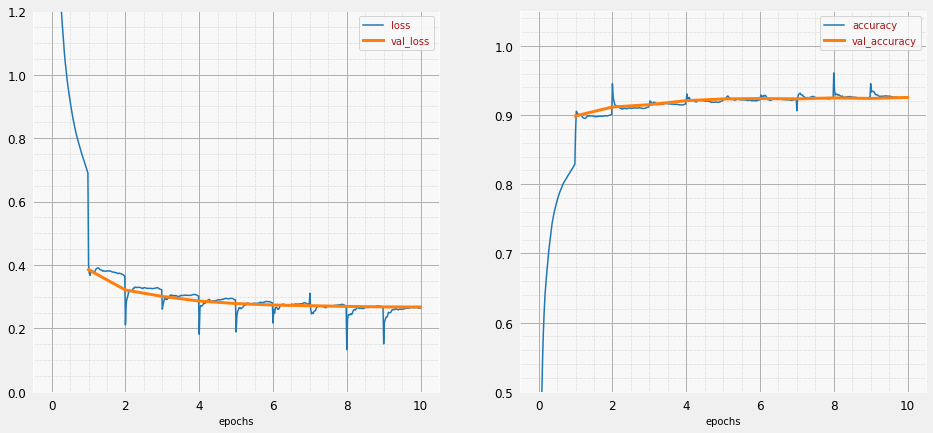

Model accuracy is 90%


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=[28, 28, 1]), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                            #  tf.keras.layers.Dense(200, activation="relu"), #Activation function used is relu for this example
                            #  tf.keras.layers.Dense(100, activation="relu"), 
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is 92%")

When the Algorithm converges nicely on the training data set it tends to have the problem of overfitting which can be handled using regularisation technique knows as dropout in keras.

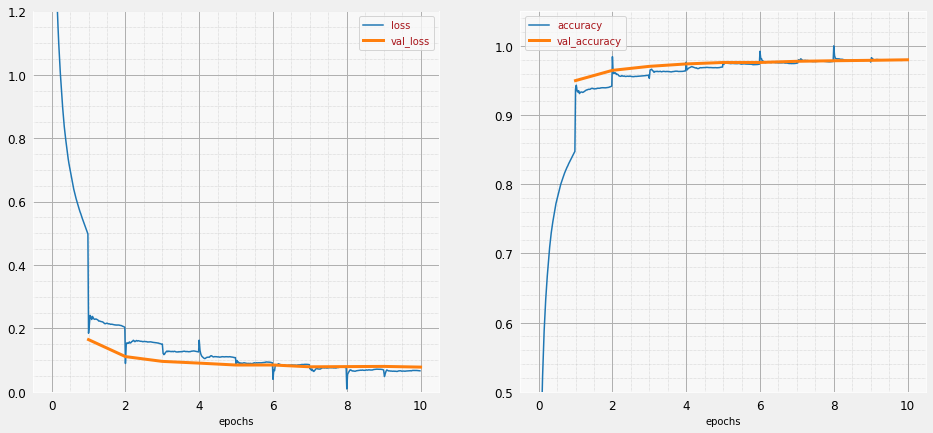

Model accuracy is around 98%. Increased on adding the dropouts to avoid overfitting


In [ ]:
#Using keras sequential model to built the model of neural network using layers of neurons.
model = tf.keras.Sequential([
                             tf.keras.layers.Input(shape=(28*28,)), # specifying the input value shape. Its 28,28 because its a 28X28 pixel image in MNIST dataset
                             tf.keras.layers.Dense(200, activation="relu"), #Activation function used is sigmoid for this example
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(100, activation="relu"),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(60, activation="relu"), 
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(10, activation="softmax") #here we are classifying 10 classes in MINST dataset therefore 10 value is passed in the dense function
])
#Model training using loss function of cross entropy and accuracy metrics
model.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
model.summary()
# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=16)
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training])
print("Model accuracy is around 98%. Increased on adding the dropouts to avoid overfitting")

# **Convolutional Network**

Convolutional Neural Network is the series of learnable input to the image. It is defined by
- filter size
- number of filters
- stride

Input and output in this layer has 3 dimensions. Width, height and number of channels.
With stride 2 or 3 we can shrink the resulting data cube using 2 techniques
- Strided Convolution - with stride > 1
- Max Pooling - sliding window applying the maximum operation

After last convolutional layer, data is in form of cube. We can feed the data in 2 ways to the dense layer
- Flatten the cube value into vector and give it to softmax layer or add a expensive dense layer before the final softmax activation function.
- split the incoming data cube into many parts as classes, average their values and give it to softmax activation function.

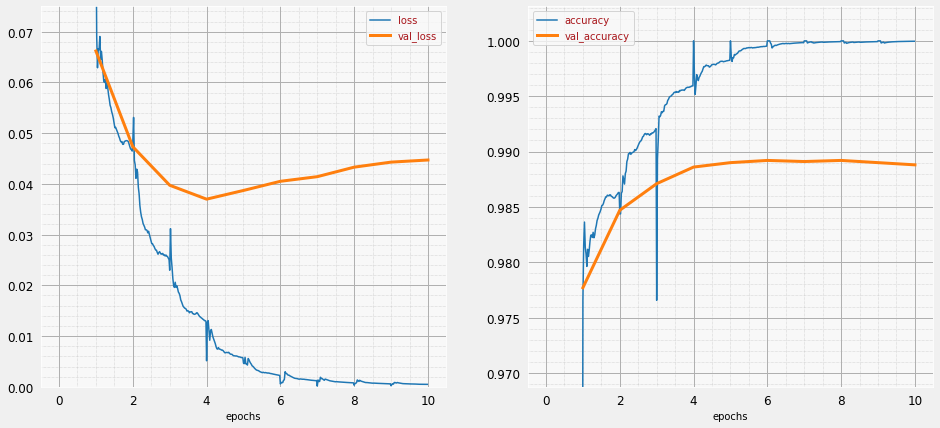

In [ ]:
convolutional_model = tf.keras.Sequential([
  #tf.keras.layers.Input(shape=(28*28,)),                                         
  tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
  tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
  tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
convolutional_model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=16)
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = convolutional_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

In [ ]:
N=15
font_digits, font_labels = create_digits_from_local_fonts(N)
probabilities = model.predict(font_digits, steps=1)
predicted_labels = np.argmax(probabilities, axis=1)
display_digits(font_digits, predicted_labels, font_labels, "predictions from local fonts (bad predictions in red)", N)

**Dropout**


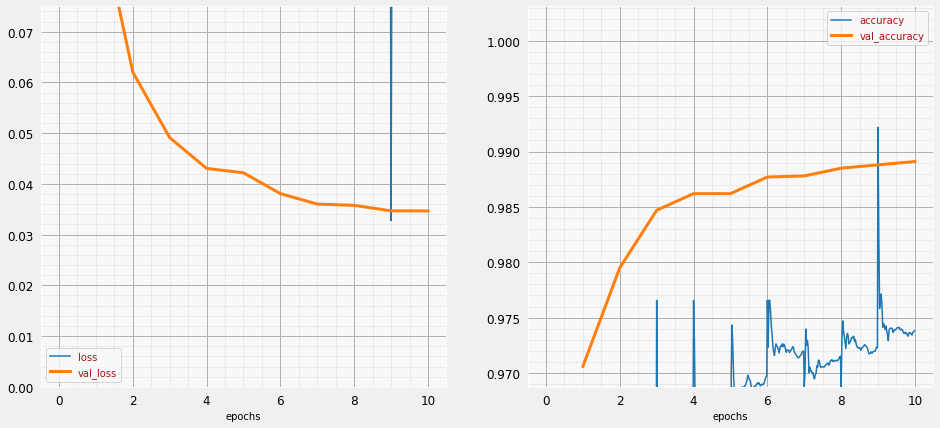

In [ ]:
convolutional_model = tf.keras.Sequential([
  #tf.keras.layers.Input(shape=(28*28,)),                                         
  tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation='relu', padding='same'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(kernel_size=6, filters=24, activation='relu', padding='same', strides=2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Conv2D(kernel_size=6, filters=32, activation='relu', padding='same', strides=2),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(200, activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(10, activation='softmax')
])
convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
convolutional_model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=16)
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = convolutional_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])

**Batch normalization**
It address the problem that how neurons output are distributed relatively to the activation function. To fix this, it normalises the neuron output across the training batch data. It introduces 2 new variables per neuron alpha and beta.

So the new equation is *alpha.normalised_output + beta*
Some tips
- goes between the output of a layer and its activation function.
- If center=True in batch norm, you do not need biases in your layer. The batch norm offset plays the role of a bias.
- If activation function that is scale-invariant (i.e. does not change shape if you zoom on it) then you can set scale=False. Relu is scale-invariant. Sigmoid is not.


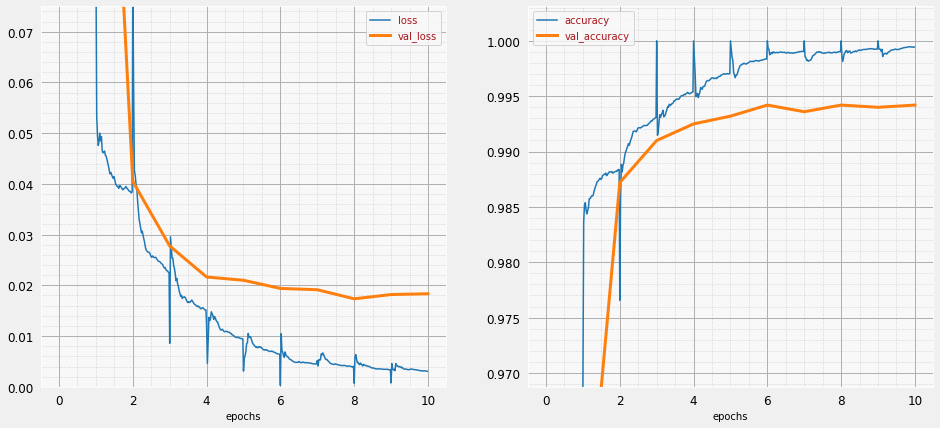

In [ ]:
convolutional_model = tf.keras.Sequential([
  tf.keras.layers.Reshape(input_shape=(28*28,), target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same'),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  
  tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  
  tf.keras.layers.Conv2D(kernel_size=6, filters=32, use_bias=False, padding='same', strides=2),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  
  tf.keras.layers.Flatten(),
  
  tf.keras.layers.Dense(200, use_bias=False),
  tf.keras.layers.BatchNormalization(center=True, scale=False),
  tf.keras.layers.Activation('relu'),
  
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(10, activation='softmax')
])

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='categorical_crossentropy',metrics=['accuracy'])
convolutional_model.summary()
plot_training = PlotTraining(sample_rate=10, zoom=16)
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)

history = convolutional_model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=1, callbacks=[plot_training, lr_decay_callback])